In [1]:
#Retrieving dataset from Google Drive
MODE = "MOUNT"
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass

Mounted at /content/drive


In [2]:
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, Dense, Dropout, Activation, Embedding, Flatten, BatchNormalization, merge, Input, Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, LSTM
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.applications.resnet import ResNet50
#Preprocessing Input to suit the needs of ResNet and avoid the need for Batch normalization
from keras.applications.resnet import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import os
import cv2

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
PATH_TO_DATA_SET = '/content/drive/My Drive/resized128N/resized128N'

epochs = 10
batch_size = 32
image_size = 128
input_shape = (image_size, image_size, 3)

#Loading training dataset into a dataframe
data_set = os.listdir(PATH_TO_DATA_SET)

categories = []
for filename in data_set:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': data_set,
    'category': categories
})

# dance_map = { 'ballet': 0, 'bharatnatyam': 1, 'break': 2, 'flamenco': 3 }
# df['category'] = df['category'].map(dance_map)
unique_vals, unique_vals_count = np.unique(df['category'], return_counts = True)
print(unique_vals, unique_vals_count)
# df['category'] = to_categorical(df['category'], num_classes = 4)
# print(df['category'].unique())

train_df = df
df.head(5)

['ballet' 'bharatnatyam' 'break' 'flamenco' 'square' 'waltz'] [ 827 1062  774  947 1183  982]


,filename,category
0,square.1160.jpg,square
1,square.1140.jpg,square
2,square.1173.jpg,square
3,square.117.jpg,square
4,square.1103.jpg,square


In [4]:
#Splitting data into train, test and validation sets
ind = np.random.rand(len(train_df)) < 0.8 #80% of data is training
train_df, rem_df = train_df[ind], train_df[~ind]
train_df = train_df.reset_index()
rem_df = rem_df.reset_index()

ind = np.random.rand(len(rem_df)) < 0.5 #50% of the remaining data is split between validation and test
validate_df, test_df = rem_df[ind], rem_df[~ind]
test_df = test_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [5]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    rescale=1/255,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    PATH_TO_DATA_SET, 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)


validation_datagen = ImageDataGenerator(
  dtype='float32',
  rescale=1/255,
  preprocessing_function=preprocess_input
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    PATH_TO_DATA_SET, 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(
  dtype='float32',
  rescale=1/255,
  preprocessing_function=preprocess_input
)


test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    PATH_TO_DATA_SET, 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 4625 validated image filenames belonging to 6 classes.
Found 587 validated image filenames belonging to 6 classes.
Found 563 validated image filenames belonging to 6 classes.


In [6]:
from keras.layers import Input, Lambda

model_lstm = Sequential()
model_lstm.add(Lambda(lambda x: x[:,:,:,0], input_shape=input_shape))
model_lstm.add(LSTM(units=256, return_sequences=True))
model_lstm.add(LSTM(units=128, return_sequences=True))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dense(128))
model_lstm.add(Dense(6, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(clipvalue=0.5), metrics=['accuracy'])
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 128, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 128, 256)          394240    
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          197120    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 649,862
Trainable params: 649,862
Non-trai

In [7]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 4.0 MB/s 


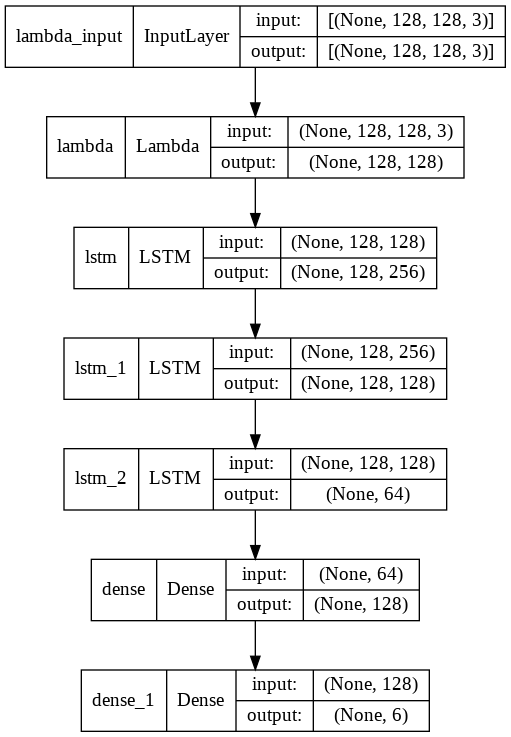

In [8]:
import visualkeras

# visualkeras.layered_view(model_lstm).show() # display using your system viewer
# visualkeras.layered_view(model_lstm, to_file='lstm_model.png').show() # write and show

# visualkeras.layered_view(model_lstm, legend=True)

tf.keras.utils.plot_model(model_lstm, to_file='lstm_model_arch.png', show_shapes=True)

In [9]:
checkpoint = ModelCheckpoint(
    'lstm_best_model.hdf5',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', period=1)
early = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.1, 
    patience=5, 
    verbose=1, 
    mode='auto')

lstm_history = model_lstm.fit(train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks = [checkpoint, early])

Epoch 1/10
144/144 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.5038
Epoch 00001: val_loss improved from inf to 0.27318, saving model to lstm_best_model.hdf5
144/144 [==============================] - 79s 84ms/step - loss: 0.3409 - accuracy: 0.5038 - val_loss: 0.2732 - val_accuracy: 0.6545
Epoch 2/10
144/144 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.7281
Epoch 00002: val_loss improved from 0.27318 to 0.22064, saving model to lstm_best_model.hdf5
144/144 [==============================] - 9s 62ms/step - loss: 0.2127 - accuracy: 0.7281 - val_loss: 0.2206 - val_accuracy: 0.7205
Epoch 3/10
144/144 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.7988
Epoch 00003: val_loss improved from 0.22064 to 0.12725, saving model to lstm_best_model.hdf5
144/144 [==============================] - 9s 62ms/step - loss: 0.1654 - accuracy: 0.7988 - val_loss: 0.1273 - val_accuracy: 0.8628
Epoch 4/10
144/144 [====================

{'loss': [0.34086912870407104, 0.212727889418602, 0.16541215777397156, 0.12792237102985382, 0.1262407898902893, 0.09442148357629776, 0.06280605494976044, 0.06238512694835663], 'accuracy': [0.5038101673126221, 0.7280644178390503, 0.7988243103027344, 0.8497713804244995, 0.8554321527481079, 0.894622266292572, 0.9316350817680359, 0.9351186752319336], 'val_loss': [0.2731771767139435, 0.22064058482646942, 0.1272522509098053, 0.10916700959205627, 0.12491520494222641, 0.0749233216047287, 0.05733662098646164, 0.04945497587323189], 'val_accuracy': [0.6545138955116272, 0.7204861044883728, 0.8628472089767456, 0.8697916865348816, 0.8489583134651184, 0.9097222089767456, 0.9392361044883728, 0.9565972089767456]}


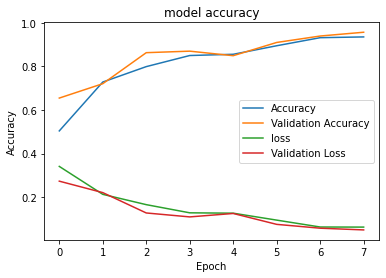

In [10]:
import matplotlib.pyplot as plt
print(lstm_history.history)
plt.plot(lstm_history.history["accuracy"])
plt.plot(lstm_history.history['val_accuracy'])
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [11]:
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)
    
def plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 3)), 3, figsize=(10, 12))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


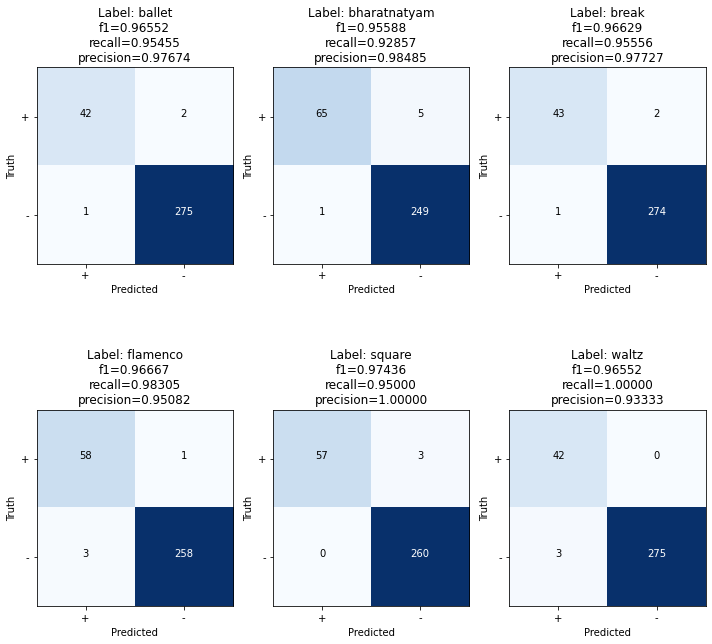

In [12]:
import sys
import itertools
from sklearn.metrics import multilabel_confusion_matrix

label_to_class = {v: k for k, v in train_generator.class_indices.items()}
def array_to_labels(onehot_array, label_to_class):
    labels = []
    idx = np.where(onehot_array == 1)[0]
    return [label_to_class[i] for i in idx]

nr_batches = 10
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(validation_generator, 2)
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(nr_batches)).astype('int')
y_pred = (model_lstm.predict_generator(img_iter_val_1, steps=nr_batches) > threshold).astype('int')
plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


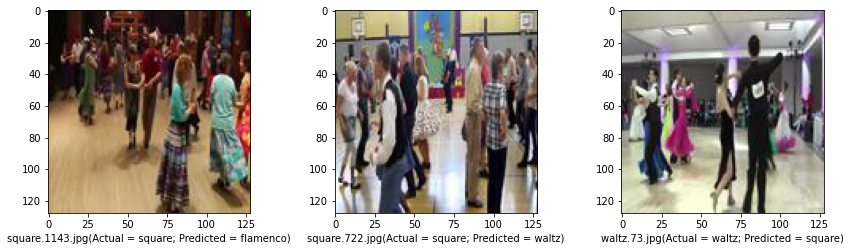

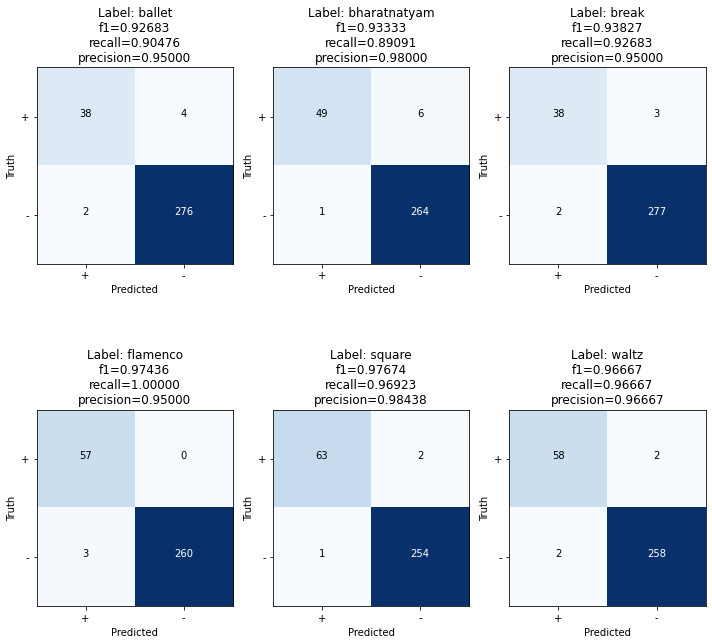

In [16]:
class_to_label = {0: 'ballet', 1: 'bharatnatyam', 2:'break', 3: 'flamenco', 4: 'square', 5: 'waltz'}
def array_to_labels(onehot_array, label_to_class):
    labels = []
    idx = np.where(onehot_array == 1)[0]
    return [label_to_class[i] for i in idx]

nr_batches = 10
threshold = 0.5
img_iter_test_0, img_iter_test_1 = itertools.tee(test_generator, 2)
y_true = np.vstack(next(img_iter_test_0)[1] for _ in range(nr_batches)).astype('int')
y_pred = (model_lstm.predict_generator(img_iter_test_1, steps=nr_batches) > threshold).astype('int')
fnames = test_generator.filenames ## fnames is all the filenames/samples used in testing
categories = np.asarray(test_generator.classes)
y_pred = np.squeeze(y_pred)

category_list = []
predicted_list = []
for i in range(len(y_pred)):
  if 1 in y_pred[i]:
    category_list.append(class_to_label[categories[i]])
    predicted_list.append(array_to_labels(y_pred[i], label_to_class)[0])
    # print(class_to_label[categories[i]], array_to_labels(y_pred[i], label_to_class)[0])
errors = np.where(np.asarray(predicted_list) != np.asarray(category_list))[0] ## misclassifications done on the test data where y_pred is the predicted values
plt.figure(figsize=(12, 12))

errors = [0, 80, 160]
display_errors = 0
for i in errors[:]:
  filename = fnames[i]
  category = categories[i]
  img = load_img(PATH_TO_DATA_SET + '/'+ filename, target_size=input_shape)
  plt.subplot(3, 3, display_errors+1)
  plt.imshow(img)
  plt.xlabel(filename + '(' + "Actual = {}".format(category_list[i]) + "; Predicted = {}".format(predicted_list[i]) + ')' )
  display_errors = display_errors + 1
plt.tight_layout()
plt.show()

plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=True)